In [ ]:
import os
import pathlib
import time
import datetime
from matplotlib import pyplot as plt
from IPython import display
import tensorflow as tf
tf.__version__

'2.10.0'

In [ ]:
dataset = 'maps'

In [ ]:
dataset_file = "{}.tar.gz".format(dataset)
dataset_url = "http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{}".format(dataset_file)
print(dataset_url)

http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz


In [ ]:
download_zip = tf.keras.utils.get_file(fname = dataset_file, origin = dataset_url, extract = True)
download_zip = pathlib.Path(download_zip)
path = download_zip.parent/dataset

In [ ]:
list(path.parent.iterdir())

[WindowsPath('C:/Users/iamsu/.keras/datasets/maps'),
 WindowsPath('C:/Users/iamsu/.keras/datasets/maps.tar.gz'),
 WindowsPath('C:/Users/iamsu/.keras/datasets/mnist.npz')]

In [ ]:
sample = tf.io.read_file(str(path / 'train/3.jpg'))
sample = tf.io.decode_jpeg(sample)

(600, 1200, 3)


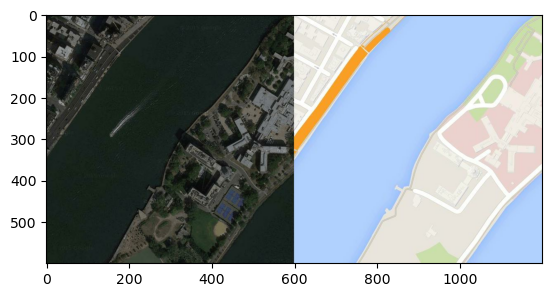

In [ ]:
print(sample.shape)
plt.figure()
plt.imshow(sample);

In [ ]:
def load_image(img_file):
    img = tf.io.read_file(img_file)
    img = tf.io.decode_jpeg(img)

    img = tf.image.resize(img, [256,512])
    width = tf.shape(img)[1]
    width = width // 2
    original_img = img[:, :width, :]
    transformed_img = img[:, width:, :]
    original_img = tf.cast(original_img, tf.float32)
    transformed_img = tf.cast(transformed_img, tf.float32)
    return original_img,transformed_img

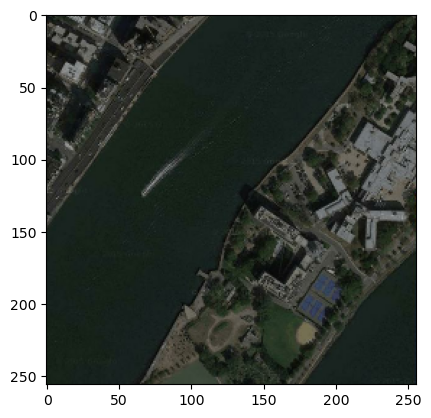

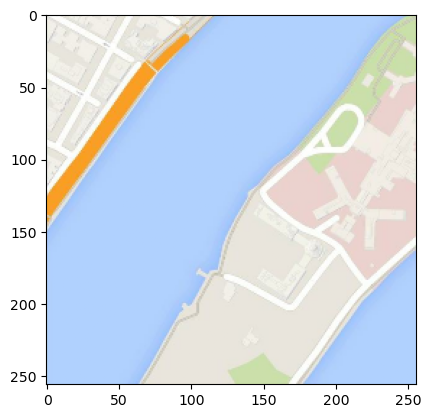

In [ ]:
original_img, transformed_img = load_image(str(path / 'train/3.jpg'))
plt.figure()
plt.imshow(original_img / 255.0)
plt.figure()
plt.imshow(transformed_img / 255.0);

In [ ]:
quantity_training = tf.data.Dataset.list_files(str(path / 'train/*.jpg'))
quantity_training

<ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:
quantity_training = len(list(quantity_training))
quantity_training

1096

In [ ]:
buffer_size = quantity_training
batch_size = 1
img_width = 256
img_height = 256

In [ ]:
def resize(original,transformed, img_width,img_height):
    original = tf.image.resize(original, [img_width,img_height], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    transformed = tf.image.resize(transformed, [img_width,img_height], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return original,transformed

In [ ]:
def normalize(original,transformed):
    original = (original / 127.5) - 1
    transformed = (transformed / 127.5) - 1
    return original,transformed

In [ ]:
def random_crop(original,transformed):
    stacked = tf.stack([original,transformed], axis = 0)
    crops = tf.image.random_crop(stacked, [2,img_width,img_height,3])
    return crops[0] , crops[1]

In [ ]:
@tf.function
def random_jitter(original,transformed):
    original,transformed = resize(original,transformed, 286,286)
    original,transformed = random_crop(original,transformed)
    if tf.random.uniform(()) > 0.5:
        original = tf.image.flip_left_right(original)
        transformed = tf.image.flip_left_right(transformed)
    return original,transformed

In [ ]:
tf.random.uniform(())

<tf.Tensor: shape=(), dtype=float32, numpy=0.24795794>

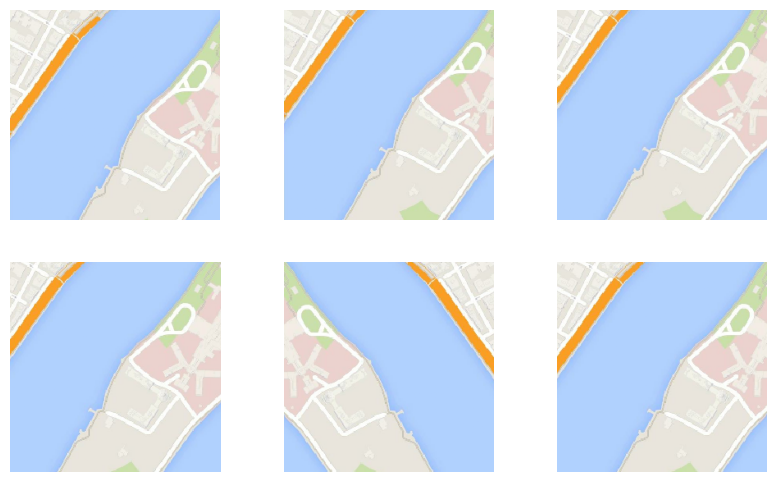

In [ ]:
plt.figure(figsize = (10,6))
for i in range(6):
  j_original, j_transformed = random_jitter(original_img, transformed_img)
  plt.subplot(2,3, i + 1)
  plt.imshow(j_transformed / 255.0)
  plt.axis('off')
plt.show()

In [ ]:
def load_training_images(img_file):
    original,transformed = load_image(img_file)
    original,transformed = random_jitter(original,transformed)
    original,transformed = normalize(original,transformed)
    return original,transformed

In [ ]:
def load_testing_images(img_file):
    original,transformed = load_image(img_file)
    original,transformed = resize(original,transformed,img_width,img_height)
    original,transformed = normalize(original,transformed)
    return original,transformed

In [ ]:
training_dataset = tf.data.Dataset.list_files(str(path/'train/*.jpg'))
training_dataset = training_dataset.map(load_training_images , num_parallel_calls=tf.data.AUTOTUNE)
training_dataset = training_dataset.shuffle(buffer_size)
training_dataset = training_dataset.batch(batch_size)

In [ ]:
try :
    testing_dataset = tf.data.Dataset.list_files(str(path/'test/*.jpg'))
except tf.errors.InvalidArgumentError:
    testing_dataset = tf.data.Dataset.list_files(str(path/'val/*.jpg'))
testing_dataset = testing_dataset.map(load_testing_images)
testing_dataset = testing_dataset.batch(batch_size)

In [ ]:
testing_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None))>

In [ ]:
training_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [ ]:
def encode(filters,size,apply_batchnorm = True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters,size,strides= 2,padding = 'same',
                                              kernel_initializer= initializer,use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [ ]:
def decode(filters,size,apply_dropout = False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters,size,strides = 2, padding = 'same',
                                     kernel_initializer=initializer,use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [ ]:
download = encode(3,2)
result = download(tf.expand_dims(original_img,0))
result.shape

TensorShape([1, 128, 128, 3])

In [ ]:
de = decode(3,4)
re = de(result)
re.shape

TensorShape([1, 256, 256, 3])

In [ ]:
def Generator():
    inputs= tf.keras.layers.Input(shape = [256,256,3])

    downsampling = [
        encode(64,4,False),
        encode(128,4),
        encode(256,4),
        encode(512,4),
        encode(512,4),
        encode(512,4),
        encode(512,4),
        encode(512,4)
    ]

    upsampling = [
        decode(512,4,True),
        decode(512,4,True),
        decode(512,4,True),
        decode(512,4),
        decode(256,4),
        decode(128,4),
        decode(64,4),
    ]

    output_channels = 3
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(output_channels,4,strides = 2,padding = 'same',
                                          kernel_initializer = initializer , activation = 'tanh')

    skips = []
    x = inputs
    for down in downsampling:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up,skip in zip(upsampling,skips):
        x = up(x)
        x = tf.keras.layers.concatenate([x,skip])

    x = last(x)
    return tf.keras.Model(inputs = inputs , outputs = x )

In [ ]:
generator = Generator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


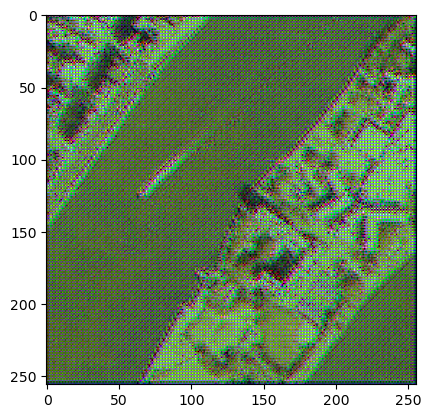

In [ ]:
g_output = generator(original_img[tf.newaxis, ...], training=False)
plt.imshow(g_output[0, ...])

In [ ]:
lr = 0.0002
beta1, beta2 = 0.5, 0.999
lambda_ = 100

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0.,0.02)
    original = tf.keras.layers.Input(shape = [256,256,3], name = 'original_img')
    transformed = tf.keras.layers.Input(shape = [256,256,3], name = 'transformed_img')
    x = tf.keras.layers.concatenate([original,transformed])
    down1 = encode(64,4,False)(x)
    down2 = encode(128,4)(down1)
    down3 = encode(256,4)(down2)
    zero_pad = tf.keras.layers.ZeroPadding2D()(down3)
    last = tf.keras.layers.Conv2D(512,4,1,kernel_initializer= initializer,use_bias=False)(zero_pad)
    batchnorm = tf.keras.layers.BatchNormalization()(last)
    leakyrelu = tf.keras.layers.LeakyReLU()(batchnorm)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(leakyrelu)
    conv = tf.keras.layers.Conv2D(1,4,1,kernel_initializer= initializer,use_bias=False)(zero_pad1)
    return tf.keras.Model(inputs = [original,transformed], outputs = conv)

In [ ]:
discriminator = Discriminator()
#tf.keras.utils.plot_model(discriminator, show_shapes= True, dpi = 64)

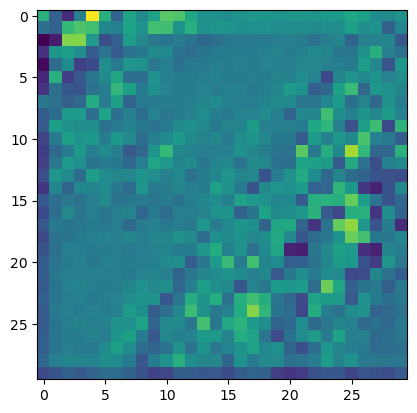

In [ ]:
d_output = discriminator([original_img[tf.newaxis, ...], g_output], training=False)
plt.imshow(d_output[0, ..., -1])

In [ ]:
def generator_loss(d_gen_output,g_output,real):
    gan_loss = loss(tf.ones_like(d_gen_output),d_gen_output)
    l1_loss = tf.reduce_mean(tf.abs(real - g_output))
    total_loss = gan_loss + (lambda_ * l1_loss)
    return total_loss , gan_loss,l1_loss

In [ ]:
def discriminator_loss(d_gen_real,d_gen_fake):
    gan_loss = loss(tf.ones_like(d_gen_real) , d_gen_real)
    l1_loss = loss(tf.zeros_like(d_gen_fake) , d_gen_fake)
    total_loss = gan_loss + l1_loss
    return total_loss

In [ ]:
def generate_image(model,test_input,real,steps = None):
    generated_image = model(test_input,training = True)
    plt.figure(figsize = (10,6))
    img_list = [test_input[0] , real[0] , generated_image[0]]
    title = ['Test Input' , 'Real' , 'Generate Image']

    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.axis('off')
        plt.imshow(img_list[i])
        plt.title(title[i])
       	plt.axis('off')
    if steps is not None:
        plt.savefig(f'pix2pix:{steps}', bbox_inches = 'tight')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


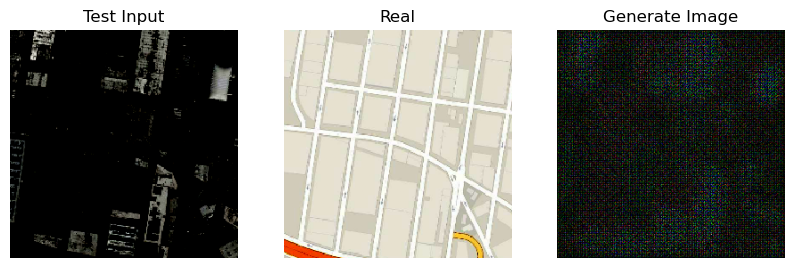

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


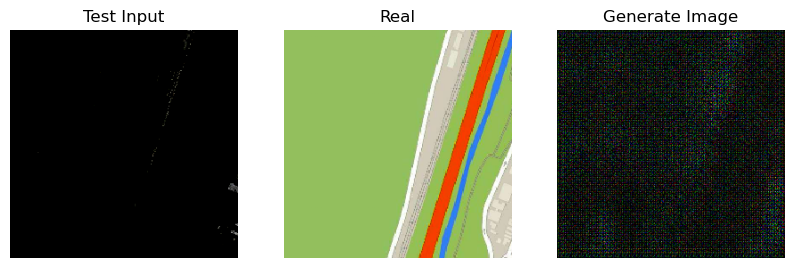

In [ ]:
for test_input,real in training_dataset.take(2):
    generate_image(generator, test_input,real)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [ ]:
path_log = 'logs/'
metrics = tf.summary.create_file_writer(path_log + 'fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
def training_steps(test_input,real,steps):
    with tf.GradientTape() as gtape ,tf.GradientTape() as dtape:
        g_output = generator(test_input,training = True)

        d_gen_real = discriminator([test_input,real] , training = True)
        d_gen_fake = discriminator([test_input , g_output], training = True)

        g_total_loss,g_gan_loss,g_l1_loss = generator_loss(d_gen_fake,g_output,real)
        d_total_loss = discriminator_loss(d_gen_real,d_gen_fake)

    generator_gradients = gtape.gradient(g_total_loss , generator.trainable_variables)
    discriminator_gradients = dtape.gradient(d_total_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients , generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients , discriminator.trainable_variables))

    with metrics.as_default():
        tf.summary.scalar('g_total_loss' , g_total_loss , step = steps // 1000)
        tf.summary.scalar('g_gan_loss' , g_gan_loss , step = steps // 1000)
        tf.summary.scalar('g_l1_loss' , g_l1_loss , step = steps // 1000)
        tf.summary.scalar('d_total_loss' , d_total_loss , step = steps // 1000)

In [ ]:
def train(training_dataset,testing_dataset,steps):
    test_input,real_input = next(iter(testing_dataset.take(2)))
    start = time.time()

    for step ,(test_img,real_img) in training_dataset.repeat().take(steps).enumerate():
        if step % 1000 == 0:
            display.clear_output(wait = True)
            if step != 0:
                print(f'Time taken to run 1000 steps :{time.time() - start:.2f}seconds \n')
            start = time.time()
            generate_image(generator,test_input,real_input,step)
            print(f'Steps :{step // 1000} K')
        training_steps(test_img,real_img,step)
        if (step + 1) % 10 == 0:
            print('.', end = '' ,flush=True)
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            generator.save_weights(f'pix2pix:{steps}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Time taken to run 1000 steps :1275.07seconds 



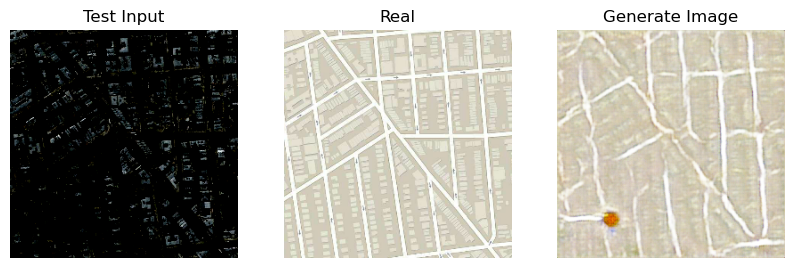

Steps :4 K
....................................................................................................

InvalidArgumentError: {{function_node __wrapped__SaveV2_dtypes_74_device_/job:localhost/replica:0/task:0/device:CPU:0}} Failed to create a directory: pix2pix:20000_temp; Invalid argument [Op:SaveV2]

In [ ]:
train(training_dataset,testing_dataset,20000)